In [1]:
import pandas as pd
from sqlalchemy import create_engine
from config import key
import scipy.stats as stats
from matplotlib import pyplot as plt

In [2]:
out_of_school = pd.read_csv("out_of_school_primary.csv", encoding='ISO-8859-1')
out_of_school.head()

,ISO3,Countries and areas,Region,Sub-region,Development Regions,Total,Female,Male,Rural_Residence,Urban_Residence,Poorest_Wealth quintile,Second_Wealth quintile,Middle_Wealth quintile,Fourth_Wealth quintile,Richest_Wealth quintile,Data source,Time period
0,AFG,Afghanistan,SA,SA,Least Developed,37.0,47.0,28.0,42.0,19.0,42.0,47.0,46.0,32.0,16.0,DHS 2015,2015.0
1,ALB,Albania,ECA,EECA,More Developed,2.0,2.0,3.0,4.0,1.0,4.0,3.0,2.0,2.0,1.0,DHS 2017-18,2018.0
2,DZA,Algeria,MENA,MENA,Less Developed,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,1.0,MICS 2012-13,2013.0
3,AND,Andorra,ECA,WE,More Developed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AGO,Angola,SSA,ESA,Least Developed,22.0,22.0,21.0,35.0,14.0,39.0,33.0,19.0,12.0,5.0,DHS 2015-16,2016.0


In [3]:
freedom_index = pd.read_csv("hfi_cc_2021.csv", encoding="ISO-8859-1")

freedom_index.head()

,year,countries,ISO,region,hf_score,hf_rank,hf_quartile,pf_rol_procedural,pf_rol_civil,pf_rol_criminal,...,ef_regulation_business_adm,ef_regulation_business_bureaucracy,ef_regulation_business_start,ef_regulation_business_bribes,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,ef_score,ef_rank
0,2019,Albania,ALB,Eastern Europe,8.14,43.0,2.0,5.97,4.76,4.26,...,5.65,6.67,9.74,6.24,5.62,7.18,6.85,7.70,7.81,31.0
1,2019,Algeria,DZA,Middle East & North Africa,5.26,154.0,4.0,5.21,5.64,4.35,...,4.22,2.22,9.31,2.58,8.77,7.03,5.69,5.84,4.90,162.0
2,2019,Angola,AGO,Sub-Saharan Africa,6.09,129.0,4.0,2.72,4.43,3.60,...,2.94,2.44,8.73,4.70,7.92,6.78,5.59,5.97,5.50,153.0
3,2019,Argentina,ARG,Latin America & the Caribbean,7.38,74.0,2.0,6.83,5.94,4.35,...,2.71,5.78,9.58,6.53,5.73,6.51,6.14,5.99,5.50,153.0
4,2019,Armenia,ARM,Caucasus & Central Asia,8.20,40.0,1.0,NaN,NaN,NaN,...,5.17,5.56,9.86,6.96,9.30,7.04,7.32,7.82,8.03,15.0


### Transform the Data to match sql database

In [4]:
# Drop unecessary columns
out_of_school = out_of_school[['ISO3','Countries and areas','Total']]
# out_of_school.head()

freedom_index = freedom_index[['ISO','countries','hf_score']]
# freedom_index.head()


In [5]:
# Rename columns to match sql column names
out_of_school.rename(columns={'ISO3':'country_code', 
                              'Countries and areas':'country_name',
                              'Total':'out_of_school'}, inplace=True)
# out_of_school.head()

freedom_index.rename(columns={'ISO':'country_code',
                              'countries':'country_name'}, inplace=True)
# freedom_index.head()

In [6]:
# Drop NaN from each dataframe
out_of_school.dropna(inplace=True)
# out_of_school.head()

freedom_index.dropna(inplace=True)
# freedom_index.head()

In [7]:
#Clean the data by dropping duplicates
out_of_school.drop_duplicates("country_code", inplace=True)
freedom_index.drop_duplicates("country_code", inplace=True)

In [8]:
#Set index to country code (primary key)
out_of_school.set_index("country_code", inplace=True)
# out_of_school.head()

freedom_index.set_index('country_code',inplace=True)
# freedom_index.head()

### Create SQL database connection

In [9]:
protocol = 'postgresql'
username = 'postgres'
password = key
host = 'localhost'
port = 5432
database_name = 'project_2_etl'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)

In [10]:
# Confirm tables
engine.table_names()

['hf_table', 'out_of_school']

In [11]:
# Load dataframes into SQL tables
out_of_school.to_sql(name='out_of_school', con=engine, if_exists='append', index=True)

freedom_index.to_sql(name='hf_table', con=engine, if_exists='append', index=True)

In [12]:
#We can do joins of the tables either in python or postgres
sql_query=r"""select hf_table.country_code, hf_table.country_name, hf_table.hf_score, out_of_school.out_of_school
FROM hf_table
JOIN out_of_school
ON out_of_school.country_code=hf_table.country_code;"""

pd.read_sql_query(sql_query, con=engine).head()

,country_code,country_name,hf_score,out_of_school
0,ALB,Albania,8.14,2.0
1,DZA,Algeria,5.26,2.0
2,AGO,Angola,6.09,22.0
3,ARG,Argentina,7.38,1.0
4,ARM,Armenia,8.20,5.0


In [13]:
# Generate correlation between HF Score and Out Of School rates using the query above
joined_df = pd.read_sql_query(sql_query, con=engine)

# Using Pearson's Correlation
correlation = stats.pearsonr(joined_df['out_of_school'], joined_df['hf_score'])
print(round(correlation[0],2))

-0.36


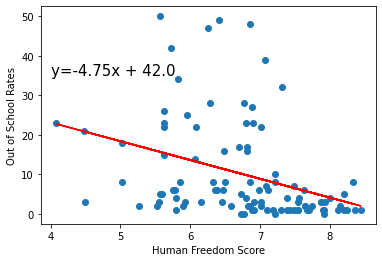

In [14]:
# Perform a linear regression on year versus violent crime rate
slope, intercept, r, p, std_err = stats.linregress(joined_df['hf_score'], joined_df['out_of_school'])

# Create equation of line to calculate predicted violent crime rate
fit = slope * joined_df['hf_score'] + intercept

# Write line equation to put into graph
line_eq = f'y={round(slope, 2)}x + {round(intercept)}'

# Plot the linear model on top of scatter plot 
plt.scatter(joined_df['hf_score'], joined_df['out_of_school'])
plt.plot(joined_df['hf_score'],fit,"r")
plt.xlabel('Human Freedom Score')
plt.ylabel('Out of School Rates')
plt.annotate(line_eq, (4, 35),fontsize=15)
plt.show()